creamos una red neuronal para la prediccion de la calidad del aire siendo 0 calidad excelente 1 muy buena y 2 buena con 3 caracteristicas y ordenados cronologicamente

importamos las bibliotecas

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


creamos una clase Model definiendo la arquitectura de la red neuronal, tendremos 3 caracteristicas de entrada, 2 capas ocultas, la primera capa con 30 neuronas, la segunda con 16 y 3 de salida

In [258]:
class Model(nn.Module):
    def __init__(self, in_entradas=3, h1=30, h2=16, out_salidas=3): #definimos la arquitectura de la red con 3 entradas 2 capas ocultas una de 30 y la otra de 16 y 3 salidas
        super(Model, self).__init__()
        self.fc1 = nn.Linear(in_entradas, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, out_salidas)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def adelante(self, x):
        x = x.to(self.device)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x
    
if(torch.cuda.is_available()):
    # verificamos si tenemos una GPU disponible
    print("Usando GPU")
else:
    print("Usando CPU")

Usando GPU


elegimos una semilla manualmente para poder elegir un numero aleatoriamente e instanciamos el modelo 

In [259]:
torch.manual_seed(5)  # Elegimos una semilla manualmente para poder elegir un numero aleatoriamente

model = Model()

importamos matplotlib

In [260]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

importamos el dataset 

In [261]:
my_data = pd.read_csv('16_air_quality_prediction.csv', sep=',')


In [262]:
#revisamos los datos
my_data

,date,location,pm2.5,pm10,temperature,predicted_aqi
0,2023-01-01,Istanbul,29.05,58.73,15.4,40.71
1,2023-01-01,Ankara,24.74,83.86,26.4,50.63
2,2023-01-01,Izmir,23.90,76.91,27.8,39.67
3,2023-01-01,Bursa,43.67,49.58,30.6,36.50
4,2023-01-02,Istanbul,28.40,76.31,23.9,46.89
...,...,...,...,...,...,...
1455,2023-12-30,Bursa,32.45,92.85,19.0,54.18
1456,2023-12-31,Istanbul,35.23,63.02,23.2,46.39
1457,2023-12-31,Ankara,45.30,47.77,8.4,44.05
1458,2023-12-31,Izmir,37.29,64.74,30.9,52.19


cambiamos valores de y

In [263]:
import numpy as np

condiciones = [
    my_data['predicted_aqi'] < 30,
    (my_data['predicted_aqi'] >= 30) & (my_data['predicted_aqi'] < 40),
    my_data['predicted_aqi'] >= 40
]
valores = [0, 1, 2]

my_data['predicted_aqi'] = np.select(condiciones, valores)

In [264]:
my_data #revisamos los datos nuevamente para verificar que se hayan cambiado los valores

,date,location,pm2.5,pm10,temperature,predicted_aqi
0,2023-01-01,Istanbul,29.05,58.73,15.4,2
1,2023-01-01,Ankara,24.74,83.86,26.4,2
2,2023-01-01,Izmir,23.90,76.91,27.8,1
3,2023-01-01,Bursa,43.67,49.58,30.6,1
4,2023-01-02,Istanbul,28.40,76.31,23.9,2
...,...,...,...,...,...,...
1455,2023-12-30,Bursa,32.45,92.85,19.0,2
1456,2023-12-31,Istanbul,35.23,63.02,23.2,2
1457,2023-12-31,Ankara,45.30,47.77,8.4,2
1458,2023-12-31,Izmir,37.29,64.74,30.9,2


eliminamos las columnas que no usaremos 

In [265]:
X = my_data[my_data['location'] == 'Istanbul'].drop('date', axis=1)
y = X['predicted_aqi']
X = X.drop(['predicted_aqi'], axis=1)
X = X.drop(['location'], axis=1)


In [266]:
#revisamos las y
y



0       2
4       2
8       2
12      2
16      2
       ..
1440    1
1444    2
1448    1
1452    2
1456    2
Name: predicted_aqi, Length: 365, dtype: int64

In [267]:
#revisamos X
X

,pm2.5,pm10,temperature
0,29.05,58.73,15.4
4,28.40,76.31,23.9
8,43.43,53.22,19.1
12,54.22,73.83,15.6
16,41.57,63.21,11.8
...,...,...,...
1440,34.31,61.09,7.9
1444,48.05,72.21,13.4
1448,33.08,70.98,24.0
1452,39.52,66.59,10.8


convertimos a arreglos de numpy 

In [268]:
X = X.values
y = y.values



In [269]:
from sklearn.model_selection import train_test_split

In [270]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.08, random_state=5) #dividimos los datos en sets de entrenamiento y prueba

In [271]:
#convertimos a tensores de pytorch
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

In [272]:
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [273]:
#fijar el criterio de perdida y cuan lejos estamos de la respuesta correcta

criterion = nn.CrossEntropyLoss() #usamos CrossEntropyLoss porque es un problema de clasificación
optimizar = torch.optim.Adam(model.parameters(), lr=0.001) #optimizamos con Adam


haremos el entrenamiento del modelo

In [274]:
#entrenamos el modelo 
epochs = 8000 #número de veces que pasamos por el dataset
losses = [] #almacenamos las pérdidas para graficarlas después
for i in range(epochs):
    # pasamos los datos por el modelo
    y_pred = model.adelante(X_train)

    # Computamos y mostramos la pérdida
    loss = criterion(y_pred, y_train.to(model.device))
    losses.append(loss.detach().cpu().numpy())
    
    if (i+1) % 10 == 0:
        print(f'Epoch {i+1}/{epochs}, Loss: {loss}')
    # Hacemos el backward pass y optimizamos
    optimizar.zero_grad()  # zero los gradientes antes de la propagación hacia atrás
    loss.backward()        # propagación hacia atrás de la pérdida
    optimizar.step()       # actualizamos los pesos

Epoch 10/8000, Loss: 0.8874428868293762
Epoch 20/8000, Loss: 0.7743121981620789
Epoch 30/8000, Loss: 0.7244768142700195
Epoch 40/8000, Loss: 0.6924058198928833
Epoch 50/8000, Loss: 0.6689456105232239
Epoch 60/8000, Loss: 0.6541666984558105
Epoch 70/8000, Loss: 0.6430277824401855
Epoch 80/8000, Loss: 0.6341796517372131
Epoch 90/8000, Loss: 0.6264813542366028
Epoch 100/8000, Loss: 0.6197729110717773
Epoch 110/8000, Loss: 0.6143017411231995
Epoch 120/8000, Loss: 0.6101847887039185
Epoch 130/8000, Loss: 0.607025146484375
Epoch 140/8000, Loss: 0.6042678356170654
Epoch 150/8000, Loss: 0.6019125580787659
Epoch 160/8000, Loss: 0.5998526215553284
Epoch 170/8000, Loss: 0.5979609489440918
Epoch 180/8000, Loss: 0.5961714386940002
Epoch 190/8000, Loss: 0.5944769382476807
Epoch 200/8000, Loss: 0.5928282737731934
Epoch 210/8000, Loss: 0.5908501744270325
Epoch 220/8000, Loss: 0.5891550183296204
Epoch 230/8000, Loss: 0.5874455571174622
Epoch 240/8000, Loss: 0.5856711268424988
Epoch 250/8000, Loss: 0.58

Text(0.5, 0, 'Epoch')

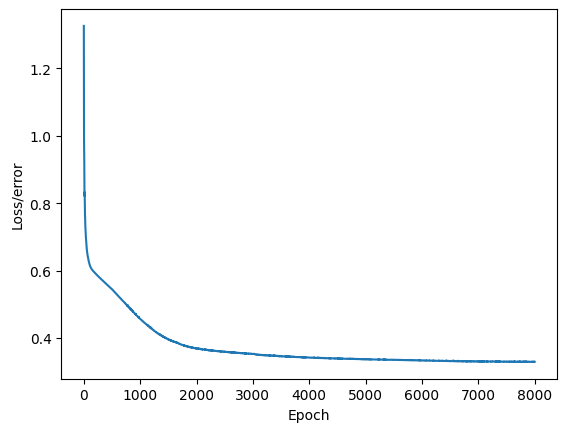

In [275]:
#lo graficamos 
plt.plot(range(epochs), losses)
plt.ylabel('Loss/error')
plt.xlabel('Epoch')

evaluamos el modelo en el set de prueba 

In [276]:
with torch.no_grad():
    # evaluamos el modelo en el set de prueba 
    y_eval = model.adelante(X_test)
    loss = criterion(y_eval, y_test.to(model.device)) #calculamos la pérdida

In [277]:
loss

tensor(0.5568, device='cuda:0')

In [278]:
correctos = 0
with torch.no_grad():
    for i, data in enumerate(X_test):
        y_val = model.adelante(data)
        
        #nos va a decir la clase con mayor probabilidad
        print(f'{i+1}.) {str(y_val)  }\t \t  {y_test[i]}\t {y_val.argmax().item()}' )

        #averiguamos si es correcto o no
        if y_val.argmax().item() == y_test[i]:
            correctos += 1

print(f'El modelo tuvo {correctos} predicciones correctas de {len(y_test)} lo cual nos da un {(correctos/len(y_test))*100}% de efectividad')




1.) tensor([-13.0072,  -5.5625,  -1.5493], device='cuda:0')	 	  2	 2
2.) tensor([-5.2525, -1.6485, -4.6498], device='cuda:0')	 	  1	 1
3.) tensor([-10.7647,  -5.4237,  -2.4053], device='cuda:0')	 	  2	 2
4.) tensor([-4.0320, -3.1517, -3.8794], device='cuda:0')	 	  1	 1
5.) tensor([-9.3843, -3.7172, -2.6031], device='cuda:0')	 	  2	 2
6.) tensor([-8.9924, -4.4036, -1.8987], device='cuda:0')	 	  2	 2
7.) tensor([-8.7380, -3.6767, -2.7016], device='cuda:0')	 	  2	 2
8.) tensor([-9.4466, -4.2879, -1.6071], device='cuda:0')	 	  2	 2
9.) tensor([-3.9758,  2.0573, -9.2230], device='cuda:0')	 	  1	 1
10.) tensor([  0.4942,   2.8299, -12.5361], device='cuda:0')	 	  0	 1
11.) tensor([-9.9467, -4.5443, -3.5527], device='cuda:0')	 	  2	 2
12.) tensor([-1.2597, -0.7714, -4.8042], device='cuda:0')	 	  0	 1
13.) tensor([-4.2533, -1.6406, -3.9478], device='cuda:0')	 	  1	 1
14.) tensor([-21.5978, -33.4082,  26.3791], device='cuda:0')	 	  2	 2
15.) tensor([-16.5688,  -2.5424,  -2.2375], device='cuda:0'